# Specifying Surface Aerosol Emissions for Simulations with Multi-Modal Aerosol
* Here we provide an approach to attribute size-resolved aerosol surface fluxes with individual aerosol modes used in LES and SCM
* Surface fluxes are taken from Jaegle et al. (2011) and aerosol modes determined from ground-based in-situ observations
* Aerosol modes help to obtain an aerosol diameter to split surface fluxes into two groups.
* Below approach delivers the fraction of total number flux (i.e., intergrated over all sizes) attributed to each of two modes
* While the total flux may change (e.g., from windspeed), the fraction remains constant.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Surface Flux according to Jaegle et al. (2011)')

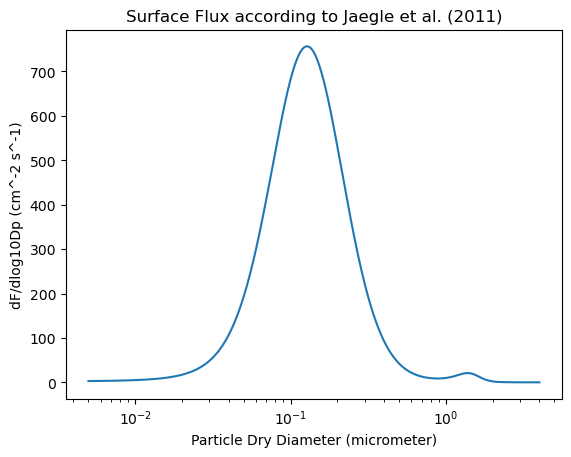

In [2]:
## use coefficients by Jaegle et al. (2011) to generate a small data base of surface flux size distribution
SST = 5
vh = 20
STEP = 0.001

JAEGLE_DAT = pd.DataFrame()
## loop over a range of diameters
for DD in np.arange(0.01,8.,STEP): 
    A = 4.7*(1 + 30 * (DD/2))**(-0.017*(DD/2)**(-1.44))
    B =(0.433 - np.log(DD/2))/0.433
    SST_TERM = (0.3 + 0.1*SST - 0.0076*SST**2.0 + 0.00021*SST**3.0)
    
    FN = SST_TERM*1.373*vh**3.41*(DD/2)**(-A)*(1+0.057*(DD/2)**3.45)*10**(1.607*np.exp(-B**2.0)) / 100 /100
    
    ## store in data frame
    TMP = pd.DataFrame([[DD/2,FN,vh,SST]],columns=['Dp','FN','vh','SST'])
    JAEGLE_DAT = pd.concat([JAEGLE_DAT,TMP])


plt.plot(JAEGLE_DAT['Dp'],JAEGLE_DAT['FN'])
plt.xscale("log",base=10)
plt.xlabel('Particle Dry Diameter (micrometer)')
plt.ylabel('dF/dlog10Dp (cm^-2 s^-1)')
plt.title('Surface Flux according to Jaegle et al. (2011)')

In [3]:
## partition into two groups and integrate over size
def split_flux(DAT,D_s,STEP):
    num_1 = np.sum(DAT.loc[DAT['Dp'] <  D_s - STEP/2]['FN'] * np.log10((DAT.loc[DAT['Dp'] <  D_s - STEP/2]['Dp']+STEP) / DAT.loc[DAT['Dp'] <  D_s- STEP/2]['Dp']))
    num_2 = np.sum(DAT.loc[DAT['Dp'] >= D_s - STEP/2]['FN'] * np.log10((DAT.loc[DAT['Dp'] >= D_s - STEP/2]['Dp']+STEP) / DAT.loc[DAT['Dp'] >= D_s - STEP/2]['Dp']))
    
    return [num_1/(num_1 + num_2),num_2/(num_1 + num_2)]

PARTITION_DAT = pd.DataFrame()
## loop over a range of diameters
for DD_split in np.arange(np.log(0.01),np.log(1.5),0.01): 
    TMP = split_flux(JAEGLE_DAT,D_s = np.exp(DD_split),STEP=STEP)
    TMP_DAT = pd.DataFrame([[TMP[0],TMP[1],np.exp(DD_split)]],columns=['num_1','num_2','D_split'])
    PARTITION_DAT = pd.concat([PARTITION_DAT,TMP_DAT])
    

Text(0.5, 1.0, 'Partitioning of Surface Flux')

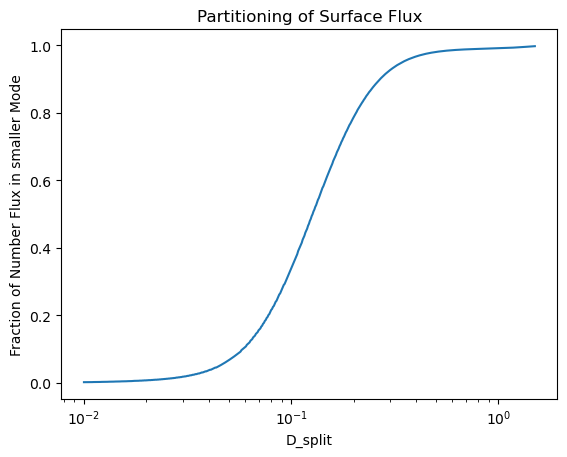

In [4]:
plt.plot(PARTITION_DAT['D_split'],PARTITION_DAT['num_1'])
plt.xscale("log")
plt.xlabel('D_split')
plt.ylabel('Fraction of Number Flux in smaller Mode')
plt.title('Partitioning of Surface Flux')

In [5]:
## utilize modes as specified by aerosol team (i.e., A. Williams and L. Russell)
PSD_zsm = pd.read_excel('https://docs.google.com/spreadsheets/d/' +
                        '1q4YkJc5dF-ZOIx-xWU_IkmTYCUPoM0kODj5ro_7Vg_c' +
                        '/export?gid=0&format=xlsx',
                        sheet_name='PSD')

## apply simple determination of splitting point based on middle mode
D_split = np.exp(np.log(PSD_zsm['D_g'][1]*1000) + 3*np.log(PSD_zsm['sigma_g'][1]))/1000
print('Splitting modes at ' + str(D_split) + 'um')

## look up proportion of flux 
PARTITION_DAT['Dp_dist'] = np.abs(PARTITION_DAT['D_split'] - D_split)
PARTITION_DAT.loc[PARTITION_DAT['Dp_dist']==PARTITION_DAT['Dp_dist'].min()]

Splitting modes at 0.57344um


,num_1,num_2,D_split,Dp_dist
0,0.98454,0.01546,0.573975,0.000535


Text(0.5, 1.0, 'Surface Flux according to Jaegle et al. (2011)')

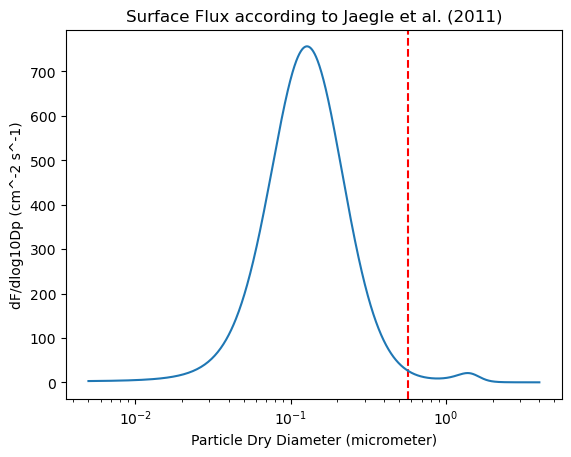

In [6]:
#plt.plot(PARTITION_DAT['D_split'],PARTITION_DAT['num_1'])
plt.axvline(x = D_split, color = 'r', ls='dashed',label = 'Splitting point determined from prevalent aerosol modes')
#plt.xscale("log")
#plt.xlabel('D_split')
#plt.ylabel('Fraction of Number Flux in smaller Mode')
#plt.title('Partitioning of Surface Flux')

plt.plot(JAEGLE_DAT['Dp'],JAEGLE_DAT['FN'])
plt.xscale("log",base=10)
plt.xlabel('Particle Dry Diameter (micrometer)')
plt.ylabel('dF/dlog10Dp (cm^-2 s^-1)')
plt.title('Surface Flux according to Jaegle et al. (2011)')

# Jaegle et al. (2011) surface particle flux integrated over all sizes
* $\text{SST}$ is sea surface skin temperature in °C
* $v_h$ is horizontal wind speed at 10 m
* $F_N$ in particle number per square centimeter and second
* For example, fluxed into the lowest atmospheric layer: $S_{srf} = \frac{F_N 10^4}{\rho \Delta z}$

$$
  F_N = 0.051682 ~ v_h^{3.41} (0.3 + 0.1 ~ \text{SST} - 0.0076 ~ \text{SST}^2 + 0.00021 ~ \text{SST}^3)
$$

<div class="alert alert-block alert-info">
<b>For MIP:</b>  Please compute interactive sea-spray fluxes using prevalent SST and 10 meter windspeed.
</div>

<div class="alert alert-block alert-warning">
<b>Update for MIP:</b>  For supercooled SST, please compute interactive sea-spray fluxes using SST = 0 °C to allow aerosol surface fluxes at all SST.
</div>